In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings('ignore')

# In this file, we using PC-Regression with Ridge Regularization, Kmeans, and Random Forest to select best portfolio

In [2]:
# Preprocess the data
data = pd.read_csv('cleaned_filtered_data.csv')
data['iPERIOD_END'] = pd.to_datetime(data['iPERIOD_END'])

# Sort data by iCIK and iPERIOD_END
data.sort_values(['iCIK', 'iPERIOD_END'], inplace=True)

In [3]:
data

,iCIK,iCUSIP,pSP_TICKER,iPERIOD_END,iQTY,iMARKET_VALUE,iLONG_FRACTION,pSP_VOLUME,pSP_OPEN,pSP_HIGH,pSP_LOW,pSP_CLOSE,daily_return,return,average_volume,volatility,turnover,market_cap
9,2230,00206R102,T,2013-12-31,539000.0,18951000.0,0.013409,18425430,35.17,35.28,34.9600,35.16,-0.000284,0.039622,18425430.0,0.272161,34.184471,18951240.00
55,2230,00817Y108,AET,2013-12-31,205000.0,14061000.0,0.009949,1565599,68.20,68.86,67.8700,68.59,0.005718,0.071384,1565599.0,0.101243,7.637068,14060950.00
72,2230,018490102,AGN,2013-12-31,120000.0,13330000.0,0.009432,1409094,110.75,111.45,109.5200,111.08,0.002980,0.228082,1409094.0,0.134075,11.742450,13329600.00
77,2230,020002101,ALL,2013-12-31,355000.0,19362000.0,0.013699,1562165,54.32,54.60,54.2000,54.54,0.004050,0.078932,1562165.0,0.110581,4.400465,19361700.00
130,2230,032511107,APC,2013-12-31,105400.0,8360000.0,0.005915,2258923,79.04,79.59,78.5400,79.32,0.003543,-0.147005,2258923.0,0.238370,21.431907,8360328.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12292825,1810099,H1467J104,CB,2020-03-31,82.0,9000.0,0.000037,3075452,112.62,113.97,110.3600,111.69,-0.008258,-0.282475,3075452.0,0.221929,37505.512195,9158.58
12292829,1810099,H2906T109,GRMN,2020-03-31,40924.0,3067000.0,0.012522,1023334,76.04,76.98,74.5700,74.96,-0.014203,-0.231652,1023334.0,0.290261,25.005718,3067663.04
12292832,1810099,H84989104,TEL,2020-03-31,153.0,9000.0,0.000037,2138457,63.11,64.27,62.0500,62.98,-0.002060,-0.342863,2138457.0,0.262627,13976.843137,9635.94
12292840,1810099,V7780T103,RCL,2020-03-31,400.0,12000.0,0.000049,26187360,28.64,35.65,28.3000,32.17,0.123254,-0.759044,26187360.0,0.441299,65468.400000,12868.00


In [19]:
unique_quarters = data['iPERIOD_END'].unique()

portfolio_returns = []
unique_quarters.sort()

previous_quarter_data = None

for idx, quarter in enumerate(unique_quarters):
    print(f"Processing Quarter {quarter}")
    quarter_data = data[data['iPERIOD_END'] == quarter].copy()

    if previous_quarter_data is not None:
        # Get the returns for the selected stocks from the next quarter
        next_quarter_returns = previous_quarter_data.loc[selected_stocks, 'return']
        
        # Calculate the weights
        weights = previous_quarter_data.loc[selected_stocks, 'iMARKET_VALUE'] / previous_quarter_data.loc[selected_stocks, 'iMARKET_VALUE'].sum()

        # Calculate the portfolio return
        portfolio_return = np.sum(weights * next_quarter_returns)
        print(f"the portfolio_return in quarter {quarter} is {portfolio_return}")
        portfolio_returns.append(portfolio_return + 1)
        #print(f"finish quarter {quarter}, going to next")
        
    scaler = StandardScaler()
    scaled_quarter_data = scaler.fit_transform(quarter_data.drop(['iCIK', 'iCUSIP', 'pSP_TICKER', 'iPERIOD_END'], axis=1))
    
    # Apply KMeans to the quarter data
    print(f"Performing Kmeans...")
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_quarter_data)
    quarter_data['cluster_labels'] = cluster_labels

    selected_stocks = []

    for cluster in np.unique(cluster_labels):
        print(f"Processing cluster {cluster}")
        cluster_data = quarter_data[quarter_data['cluster_labels'] == cluster]

        if len(cluster_data) <= 10:
            continue

        # Perform PCA on each cluster
        print(f"Processing PCA now")
        n_components = min(5, cluster_data.shape[1] - 5)
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(scaler.transform(cluster_data.drop(['iCIK', 'iCUSIP', 'pSP_TICKER', 'iPERIOD_END', 'cluster_labels'], axis=1)))

        # Principle Component Regression with Ridge Regression
        ridge_params = {'alpha': np.logspace(-3, 3, 5)}
        ridge = Ridge()
        grid_search = GridSearchCV(ridge, ridge_params, cv=5)
        grid_search.fit(principal_components, cluster_data['return'])

        # Random Forest
        print(f"Processing RF now")
        rf = RandomForestRegressor(n_estimators=50, max_depth=4)
        rf.fit(principal_components, cluster_data['return'])

        # Combine Ridge and Random Forest predictions
        combined_preds = 0.5 * grid_search.predict(principal_components) + 0.5 * rf.predict(principal_components)

        # Select top 50 performers
        top_performers_indices = np.argsort(-combined_preds)[:50]
        selected_stocks.extend(cluster_data.iloc[top_performers_indices].index)

    previous_quarter_data = quarter_data


Processing Quarter 2013-12-31T00:00:00.000000000
Performing Kmeans...
Processing cluster 0
Processing PCA now
Processing RF now
Processing cluster 1
Processing PCA now
Processing RF now
Processing cluster 2
Processing PCA now
Processing RF now
Processing cluster 3
Processing PCA now
Processing RF now
Processing cluster 4
Processing PCA now
Processing RF now
Processing Quarter 2014-03-31T00:00:00.000000000
the portfolio_return in quarter 2014-03-31T00:00:00.000000000 is 0.16423486853138033
Performing Kmeans...
Processing cluster 0
Processing PCA now
Processing RF now
Processing cluster 1
Processing PCA now
Processing RF now
Processing cluster 2
Processing PCA now
Processing RF now
Processing cluster 3
Processing PCA now
Processing RF now
Processing cluster 4
Processing PCA now
Processing RF now
Processing Quarter 2014-06-30T00:00:00.000000000
the portfolio_return in quarter 2014-06-30T00:00:00.000000000 is 0.08756856379955363
Performing Kmeans...
Processing cluster 0
Processing PCA now


In [21]:
cumulative_returns = np.cumsum(np.array(portfolio_returns)-1)
cumulative_returns

array([0.16423487, 0.25180343, 0.37384307, 0.45029347, 0.55302796,
       0.65862815, 0.72219701, 0.71183628, 0.88969184, 0.9638934 ,
       1.06855723, 1.23276963, 1.44365891, 1.52007796, 1.88430233,
       2.22817583, 2.47793919])

In [23]:
unique_quarters

array(['2013-12-31T00:00:00.000000000', '2014-03-31T00:00:00.000000000',
       '2014-06-30T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-03-31T00:00:00.000000000',
       '2015-06-30T00:00:00.000000000', '2015-09-30T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-03-31T00:00:00.000000000',
       '2016-06-30T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2017-03-31T00:00:00.000000000', '2017-06-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

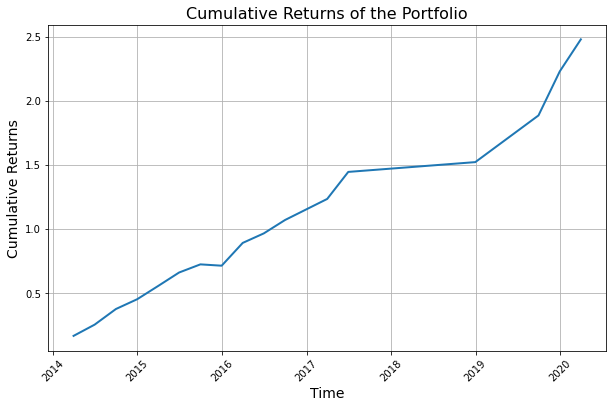

In [24]:
# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_quarters[1:], cumulative_returns, linewidth=2)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.title('Cumulative Returns of the Portfolio', fontsize=16)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

[*********************100%***********************]  1 of 1 completed


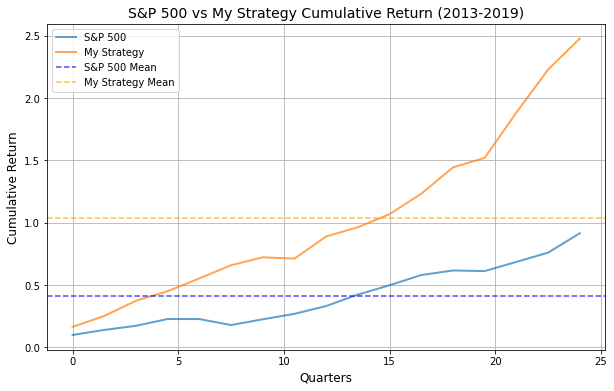

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Your cumulative returns
my_cumulative_return = np.array([0.16423487, 0.25180343, 0.37384307, 0.45029347, 0.55302796,
       0.65862815, 0.72219701, 0.71183628, 0.88969184, 0.9638934 ,
       1.06855723, 1.23276963, 1.44365891, 1.52007796, 1.88430233,
       2.22817583, 2.47793919])

# Download S&P 500 index data
ticker = "^GSPC"
start_date = "2013-09-30"
end_date = "2019-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate quarterly returns
sp500_quarterly_returns = data['Adj Close'].resample('Q').ffill().pct_change()
sp500_quarterly_returns = sp500_quarterly_returns[1:]

# Calculate cumulative return
sp500_cumulative_return = (1 + sp500_quarterly_returns).cumprod() - 1

# Interpolate missing data using linear interpolation
x_old = np.arange(len(sp500_cumulative_return))
x_new = np.linspace(0, len(sp500_cumulative_return) - 1, len(my_cumulative_return))
interpolator = interp1d(x_old, sp500_cumulative_return, kind='linear')
sp500_cumulative_return_interp = interpolator(x_new)

# Calculate the geometric mean
sp500_geom_mean = np.mean(sp500_cumulative_return_interp)
my_geom_mean = np.mean(my_cumulative_return)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_new, sp500_cumulative_return_interp, label='S&P 500', linewidth=2, alpha=0.7)
ax.plot(x_new, my_cumulative_return, label='My Strategy', linewidth=2, alpha=0.7)

# Add horizontal lines for the geometric mean
ax.axhline(y=sp500_geom_mean, color='blue', linestyle='--', label='S&P 500 Mean', alpha=0.7)
ax.axhline(y=my_geom_mean, color='orange', linestyle='--', label='My Strategy Mean', alpha=0.7)

# Customize the plot
ax.set_xlabel('Quarters', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.set_title('S&P 500 vs My Strategy Cumulative Return (2013-2019)', fontsize=14)
ax.grid()
ax.legend()

# Show the plot
plt.show()
